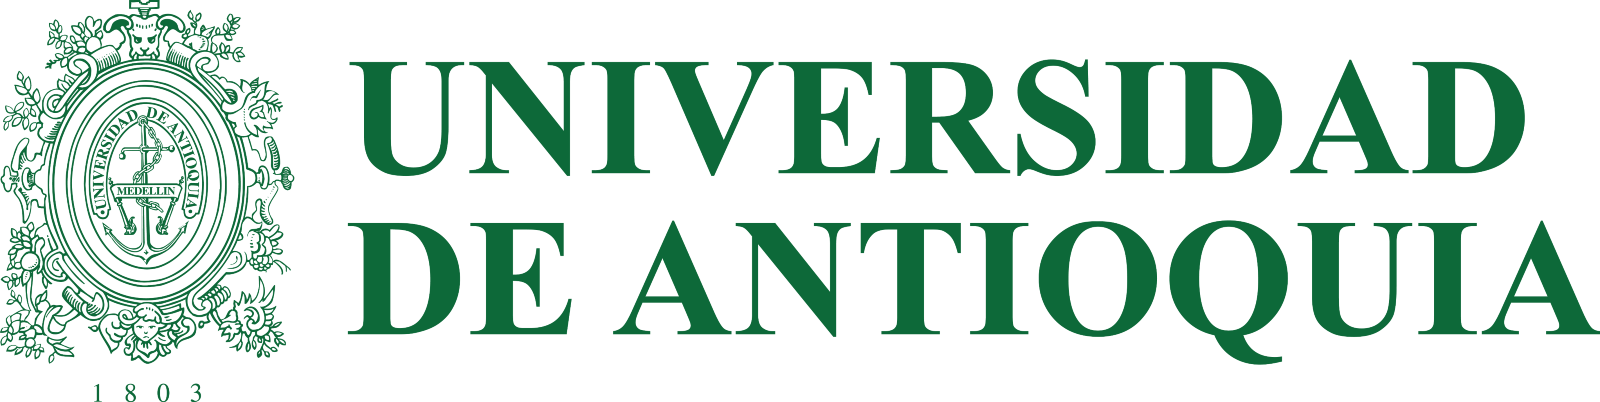

# 02 - Preprocesamiento de Datos

**Proyecto:** Análisis de Sentimiento utilizando LSTM
**Autores:** Daniel Brand Taborda, Jhonier Raúl Jiménez
**Curso:** Deep Learning 2025 - Universidad de Antioquia

## Introducción

Este notebook se encarga de tomar el dataset crudo de reseñas de películas de IMDB y aplicar una serie de pasos de preprocesamiento de texto. El objetivo es limpiar y normalizar las reseñas para que puedan ser utilizadas eficazmente por un modelo de Deep Learning (LSTM) en la tarea de clasificación de sentimientos.

Los pasos incluyen:
1.  Carga de datos.
2.  Limpieza básica: eliminación de URLs, caracteres no alfanuméricos y conversión a minúsculas.
3.  Eliminación de *stopwords* (palabras comunes sin significado semántico fuerte).
4.  Lematización: reducción de palabras a su forma raíz o lema.
5.  Codificación de etiquetas (sentimiento) a formato numérico.
6.  División del dataset en conjuntos de entrenamiento y prueba.
7.  Guardado de los datos preprocesados para su uso en notebooks posteriores.

## Configuración Inicial

Importamos las librerías necesarias y descargamos/cargamos los recursos de NLTK requeridos.

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

# --- Descargar recursos de NLTK (si no se han descargado antes) ---
# Se recomienda ejecutar esto una vez en la consola o en una celda separada
try:
    nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')
# --- Fin Descarga ---

# --- Inicializar componentes ---
stop_words = set(stopwords.words('english'))
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

print("Librerías y componentes NLTK cargados.")

Librerías y componentes NLTK cargados.


[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Carga de Datos

Cargamos el dataset original `IMDB Dataset.csv` en un DataFrame de Pandas para comenzar el proceso. Mostramos las primeras filas y la forma del DataFrame para verificar la carga.

In [6]:
DATASET_PATH = 'data/IMDB Dataset.csv' # Asegúrate que esta ruta sea correcta

try:
    data = pd.read_csv(DATASET_PATH)
    print(f"Dataset cargado exitosamente. Forma: {data.shape}")
    print("\nPrimeras 5 filas:")
    display(data.head()) # display() funciona mejor en algunos entornos de notebook
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {DATASET_PATH}")
    # Detener ejecución o manejar el error según sea necesario
    data = None # Para evitar errores posteriores si el archivo no se carga

# Revisión rápida de nulos (ya vista en EDA, pero bueno confirmar)
if data is not None:
    print("\nValores nulos por columna:")
    print(data.isnull().sum())

Dataset cargado exitosamente. Forma: (50000, 2)

Primeras 5 filas:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



Valores nulos por columna:
review       0
sentiment    0
dtype: int64


## 2. Definición de Funciones de Limpieza

Reutilizamos las funciones definidas para la limpieza básica (eliminar URLs, caracteres no alfanuméricos, convertir a minúsculas) y lematización.

In [7]:
def remove_tags(string):
    """Limpia texto: remueve URLs, caracteres no alfanuméricos (excepto espacios) y convierte a minúsculas."""
    if not isinstance(string, str):
        return ""
    result = re.sub(r'https://\S+|www\.\S+', '', string) # Remueve URLs http/https/www
    result = re.sub(r'<.*?>', '', result) # Remueve tags HTML
    result = re.sub(r'[^a-zA-Z0-9\s]', '', result) # Remueve caracteres no alfanuméricos (conserva espacios)
    result = result.lower() # Convierte a minúsculas
    return result

def lemmatize_text(text):
    """Lematiza el texto usando WordNetLemmatizer."""
    lemmatized_output = ""
    for w in w_tokenizer.tokenize(text):
        lemmatized_output += lemmatizer.lemmatize(w) + " "
    return lemmatized_output.strip()

print("Funciones de preprocesamiento definidas.")

Funciones de preprocesamiento definidas.


## 3. Limpieza Básica Aplicada

Aplicamos la función `remove_tags` a la columna 'review'. Esto estandariza el texto eliminando ruido inicial. Mostramos un ejemplo antes y después para verificar el resultado.

In [8]:
if data is not None:
    # Guardamos una copia de la columna original para comparación
    data['original_review'] = data['review']

    # Aplicamos la limpieza básica
    data['cleaned_review_step1'] = data['original_review'].apply(remove_tags)

    # Mostramos un ejemplo
    idx_example = 0 # Puedes cambiar este índice para ver otros ejemplos
    print("--- Ejemplo de Limpieza Básica ---")
    print("\nOriginal:")
    print(data['original_review'].iloc[idx_example])
    print("\nDespués de remove_tags:")
    print(data['cleaned_review_step1'].iloc[idx_example])
    print("---------------------------------")
else:
    print("No se cargaron datos, omitiendo limpieza.")

--- Ejemplo de Limpieza Básica ---

Original:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say

## 4. Eliminación de Stopwords

Eliminamos las palabras comunes (stopwords) del inglés definidas por NLTK. Esto reduce el tamaño del vocabulario y permite al modelo centrarse en palabras con mayor carga semántica. Mostramos el ejemplo después de este paso.

In [9]:
if data is not None:
    # Aplicamos la eliminación de stopwords
    data['cleaned_review_step2'] = data['cleaned_review_step1'].apply(
        lambda text: ' '.join([word for word in text.split() if word not in stop_words])
    )

    # Mostramos el mismo ejemplo
    print("--- Ejemplo después de Stopwords ---")
    print("\nAntes (solo limpieza básica):")
    print(data['cleaned_review_step1'].iloc[idx_example])
    print("\nDespués de eliminar Stopwords:")
    print(data['cleaned_review_step2'].iloc[idx_example])
    print("-----------------------------------")
else:
    print("No se cargaron datos, omitiendo stopwords.")

--- Ejemplo después de Stopwords ---

Antes (solo limpieza básica):
one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fa

## 5. Lematización

Aplicamos lematización para reducir las palabras a su forma base o diccionario (lemma). Esto ayuda a agrupar palabras con el mismo significado pero diferente forma (ej. 'running', 'runs', 'ran' -> 'run'), reduciendo aún más la complejidad del vocabulario. Usamos `WordNetLemmatizer` de NLTK.

In [10]:
if data is not None:
    # Aplicamos la lematización
    data['final_review'] = data['cleaned_review_step2'].apply(lemmatize_text)

    # Mostramos el ejemplo final
    print("--- Ejemplo después de Lematización ---")
    print("\nAntes (limpieza + stopwords):")
    print(data['cleaned_review_step2'].iloc[idx_example])
    print("\nDespués de Lematizar (Texto Final Preprocesado):")
    print(data['final_review'].iloc[idx_example])
    print("--------------------------------------")

    # Opcional: Eliminar columnas intermedias si ya no se necesitan
    # data.drop(['original_review', 'cleaned_review_step1', 'cleaned_review_step2'], axis=1, inplace=True)
    # display(data.head())
else:
    print("No se cargaron datos, omitiendo lematización.")

--- Ejemplo después de Lematización ---

Antes (limpieza + stopwords):
one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards who

## 6. Codificación de Etiquetas

La columna 'sentiment' contiene texto ('positive'/'negative'). Los modelos de machine learning requieren entradas numéricas, por lo que convertimos estas etiquetas categóricas a valores numéricos (0 y 1) usando `LabelEncoder` de Scikit-learn.

In [11]:
if data is not None:
    encoder = LabelEncoder()
    # Ajustamos y transformamos la columna 'sentiment'
    encoded_labels = encoder.fit_transform(data['sentiment'])

    # Verificamos las clases y su codificación (0 o 1)
    print(f"Clases originales: {encoder.classes_}")
    print(f"Primeras 10 etiquetas originales: {data['sentiment'].values[:10]}")
    print(f"Primeras 10 etiquetas codificadas: {encoded_labels[:10]}")

    # Añadimos las etiquetas codificadas al DataFrame (opcional, pero puede ser útil)
    data['encoded_sentiment'] = encoded_labels
else:
    print("No se cargaron datos, omitiendo codificación de etiquetas.")

Clases originales: ['negative' 'positive']
Primeras 10 etiquetas originales: ['positive' 'positive' 'positive' 'negative' 'positive' 'positive'
 'positive' 'negative' 'negative' 'positive']
Primeras 10 etiquetas codificadas: [1 1 1 0 1 1 1 0 0 1]


## 7. División en Conjuntos de Entrenamiento y Prueba

Dividimos el dataset preprocesado en un conjunto de entrenamiento (usado para entrenar el modelo) y un conjunto de prueba (usado para evaluar el rendimiento del modelo en datos no vistos). Utilizamos `train_test_split` de Scikit-learn.

* **Estratificación (`stratify=labels`):** Es crucial para asegurar que la proporción de reseñas positivas y negativas sea la misma en ambos conjuntos (entrenamiento y prueba), lo cual es importante dado que nuestro dataset original está balanceado.
* **Tamaño de Prueba:** Usaremos un 25% de los datos para el conjunto de prueba (`test_size=0.25`).
* **`random_state`:** Fijamos una semilla para que la división sea reproducible.

In [12]:
if data is not None:
    # Separamos las características (reseñas finales) y las etiquetas codificadas
    reviews = data['final_review'].values
    labels = data['encoded_sentiment'].values

    # Realizamos la división
    TEST_SPLIT_SIZE = 0.25
    RANDOM_STATE = 42 # Para reproducibilidad

    train_sentences, test_sentences, train_labels, test_labels = train_test_split(
        reviews,
        labels,
        test_size=TEST_SPLIT_SIZE,
        random_state=RANDOM_STATE,
        stratify=labels  # MUY IMPORTANTE para mantener proporción de clases
    )

    print("División de datos completada:")
    print(f"  - Muestras de Entrenamiento (Sentences): {train_sentences.shape[0]}")
    print(f"  - Muestras de Entrenamiento (Labels):    {train_labels.shape[0]}")
    print(f"  - Muestras de Prueba (Sentences):      {test_sentences.shape[0]}")
    print(f"  - Muestras de Prueba (Labels):         {test_labels.shape[0]}")

    # Verificamos la estratificación (proporción de etiquetas en cada conjunto)
    print(f"\nProporción de '1' en set entrenamiento: {np.mean(train_labels):.4f}")
    print(f"Proporción de '1' en set de prueba:      {np.mean(test_labels):.4f}")
else:
    print("No se cargaron datos, omitiendo división train/test.")

División de datos completada:
  - Muestras de Entrenamiento (Sentences): 37500
  - Muestras de Entrenamiento (Labels):    37500
  - Muestras de Prueba (Sentences):      12500
  - Muestras de Prueba (Labels):         12500

Proporción de '1' en set entrenamiento: 0.5000
Proporción de '1' en set de prueba:      0.5000


## 8. Guardado de Datos Preprocesados

Guardamos los conjuntos de entrenamiento y prueba (textos y etiquetas) en archivos separados. Esto permite que los siguientes notebooks (tokenización, modelado, evaluación) carguen directamente estos datos limpios y divididos, haciendo el flujo de trabajo más modular y eficiente, ya que no tendremos que repetir el preprocesamiento cada vez. Usaremos el formato CSV para facilitar la inspección si es necesario.

In [13]:
if data is not None:
    # Directorio para guardar los datos procesados
    output_dir = 'processed_data'
    os.makedirs(output_dir, exist_ok=True) # Crea el directorio si no existe

    # Crear DataFrames para guardar
    train_df = pd.DataFrame({'review': train_sentences, 'sentiment': train_labels})
    test_df = pd.DataFrame({'review': test_sentences, 'sentiment': test_labels})

    # Guardar los archivos CSV
    train_path = os.path.join(output_dir, 'train_processed.csv')
    test_path = os.path.join(output_dir, 'test_processed.csv')

    try:
        train_df.to_csv(train_path, index=False, encoding='utf-8')
        test_df.to_csv(test_path, index=False, encoding='utf-8')
        print(f"Datos de entrenamiento guardados en: {train_path}")
        print(f"Datos de prueba guardados en: {test_path}")
    except Exception as e:
        print(f"Error al guardar los archivos procesados: {e}")
else:
    print("No se cargaron datos, omitiendo guardado.")

Datos de entrenamiento guardados en: processed_data/train_processed.csv
Datos de prueba guardados en: processed_data/test_processed.csv
